In [36]:
import pandas as pd
import numpy as np
import time

In [37]:
data = pd.read_csv("student-data.csv")
pd.set_option('display.max_columns', None)

In [38]:
def preprocess(data):
    out = pd.DataFrame(index = data.index)
    for col,col_data in data.iteritems():
        if col_data.dtype == object:
            col_data = col_data.replace(['yes','no'],[1,0]) 
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data,prefix=col)
        out = out.join(col_data)
    return out

In [39]:
data = preprocess(data)
feature_list = data.columns[:-1]
targets = data.columns[-1]
X = data[feature_list]
y = data[targets]

In [40]:
def train_clf(clf,X_train,y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end-start

In [41]:
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    return end-start,f1_score(target, y_pred, pos_label=1)

In [42]:
def train_predict(clf, X_train, y_train, X_test, y_test):
    train_time = train_clf(clf, X_train, y_train)
    predict_train_time,predict_train_score = predict_labels(clf, X_train, y_train)
    predict_test_time,predict_test_score = predict_labels(clf, X_test, y_test)
    return {"train_size":len(X_train),"train_time":train_time,
            "train_score":predict_train_score,
            "test_time":predict_test_time,"test_score":predict_test_score}

In [43]:
def get_scores(clf, X_train, y_train, X_test, y_test):
    perf = []
    for size in [100,200,300]:
        perf.append(train_predict(clf, X_train[:size], y_train[:size], X_test, y_test))
    return pd.DataFrame.from_records(perf,index="train_size")

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from collections import defaultdict
from sklearn.cross_validation import train_test_split
def classifiers(X,y,cv=None):
    if not cv:
        clfs = {}
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.24,random_state=42)
        for clf in [MultinomialNB(),LogisticRegression(),SVC()]:
            clfs[clf.__class__.__name__] = get_scores(clf,X_train,y_train,X_test,y_test)
        return clfs
    else:
        clfs = defaultdict(list)
        devs = defaultdict(list)
        for clf in [MultinomialNB(),LogisticRegression(),SVC()]:
            for train,test in cv:
                X_train,y_train,X_test,y_test = X.iloc[train],y.iloc[train],X.iloc[test],y.iloc[test]
                clfs[clf.__class__.__name__].append(get_scores(clf,X_train,y_train,X_test,y_test))
        for clf,perf in clfs.iteritems():
            df = pd.DataFrame()
            for d in perf:
                df = df.append(perf)
            clfs[clf] = df.groupby(df.index).mean()
            devs[clf] = df.groupby(df.index).std()
        return clfs,devs

In [45]:
%matplotlib inline
from matplotlib import pylab
def plotter(clfs,devs=None,**kwargs):
    if kwargs is not None:
        for metric in [key for key,value in kwargs.items() if value]:
            for key,value in clfs.items():
                pylab.plot(value.index,value[metric],label=key)
                pylab.xlabel(value.index.name)
                pylab.ylabel(value[metric].name)
                pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                pylab.grid()
                title = "".join([value.index.name," vs ",value[metric].name])
                pylab.title(title)
                if devs:
                    pylab.fill_between(value.index, value[metric] - devs[key][metric],
                                       value[metric] + devs[key][metric], alpha=0.1,color="r")
            pylab.show()

In [46]:
#plotter(clfs,test_score=True,train_score=True,test_time=True,train_time=True)

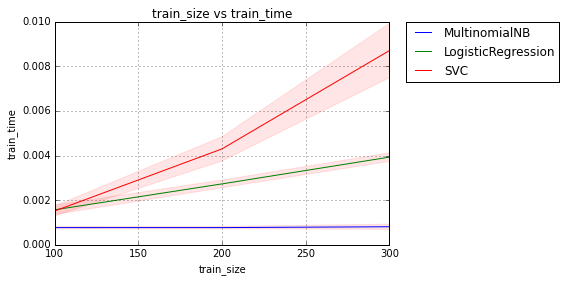

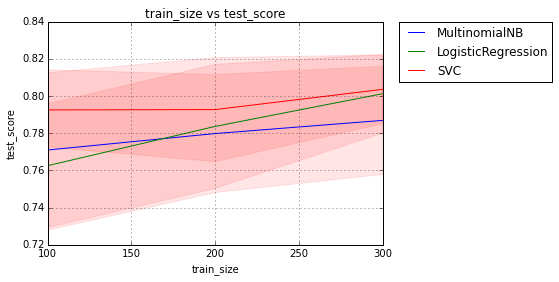

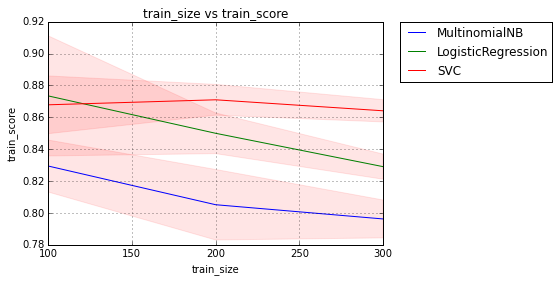

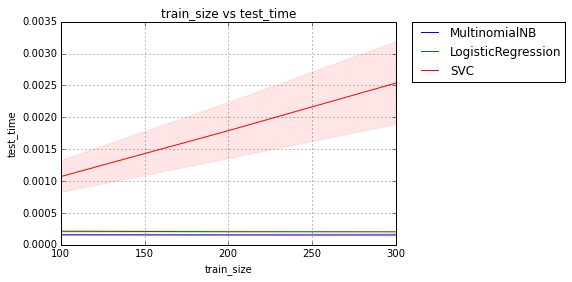

In [47]:
from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(y,n_iter=10,test_size=.24)
clfs,devs = classifiers(X,y,cv=cv)
plotter(clfs,devs,test_score=True,train_score=True,test_time=True,train_time=True)

In [48]:
from sklearn.preprocessing import MinMaxScaler

def scaling(X):
    scaler = MinMaxScaler()
    X.age = scaler.fit_transform(X.age)
    X.absences = scaler.fit_transform(X.absences)
    return X

In [49]:
x = scaling(X)
cv = StratifiedShuffleSplit(y,n_iter=10,test_size=.24)
clfs,devs = classifiers(X,y,cv=cv)
clfs_with,devs_with = classifiers(x,y,cv=cv)
print clfs["SVC"]
print clfs_with["SVC"]

            test_score  test_time  train_score  train_time
train_size                                                
100           0.807427   0.001141     0.831717    0.001558
200           0.812565   0.001926     0.841309    0.004388
300           0.823297   0.002640     0.838591    0.009242
            test_score  test_time  train_score  train_time
train_size                                                
100           0.811051   0.001208     0.834756    0.001586
200           0.814697   0.002074     0.841856    0.004691
300           0.821284   0.003004     0.840560    0.009651


/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/bharat/anaconda

In [50]:
X_tr,X_ts,y_tr,y_ts = train_test_split(X,y,test_size=.25)
lrclf = LogisticRegression(C=0.08,penalty='l1')

In [51]:
lrclf.fit(X_tr,y_tr)
pred = lrclf.predict(X_ts)
f1_score(pred,y_ts,pos_label=1)

0.84146341463414631

In [52]:
X_tr,X_ts,y_tr,y_ts = train_test_split(X,y,test_size=.25)
svclf = SVC(C=0.08)
svclf.fit(X_tr,y_tr)
pred = lrclf.predict(X_ts)
f1_score(pred,y_ts,pos_label=1)

0.77551020408163274